In [102]:
!pip install tensorflow numpy matplotlib opencv-python




[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [175]:
import tensorflow as tf
import os 
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from keras.optimizers import Adam

In [104]:

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)


In [105]:
data_dir = 'data' 
image_exts = ['jpeg','jpg', 'bmp', 'png']
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

In [106]:
data = tf.keras.utils.image_dataset_from_directory('data',batch_size = 16)
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

Found 8005 files belonging to 2 classes.


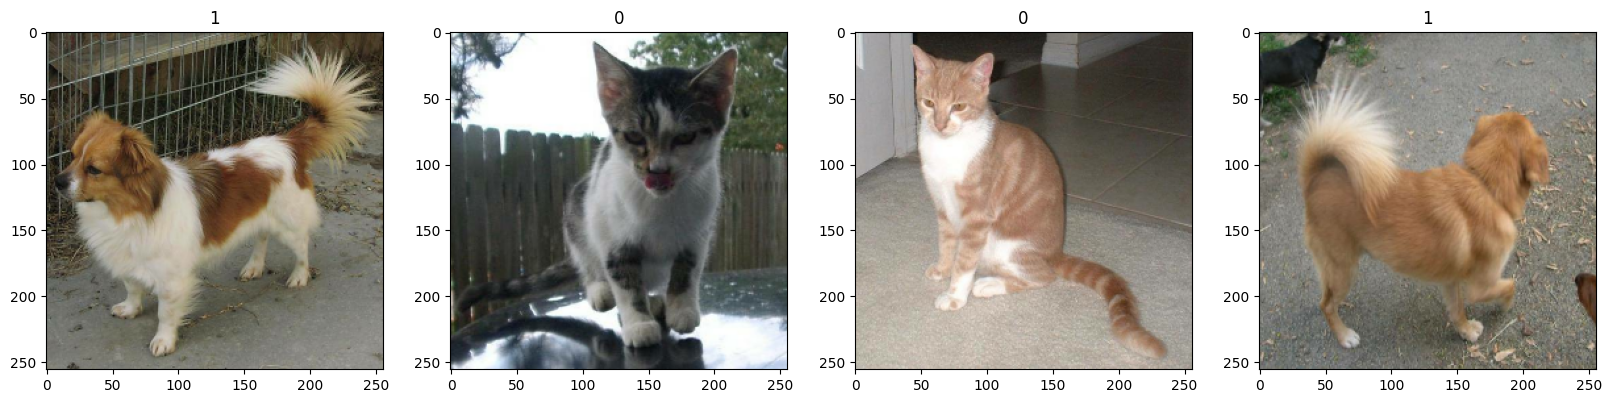

In [109]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [110]:

data = data.map(lambda x,y: (x/255, y))
data.as_numpy_iterator().next()

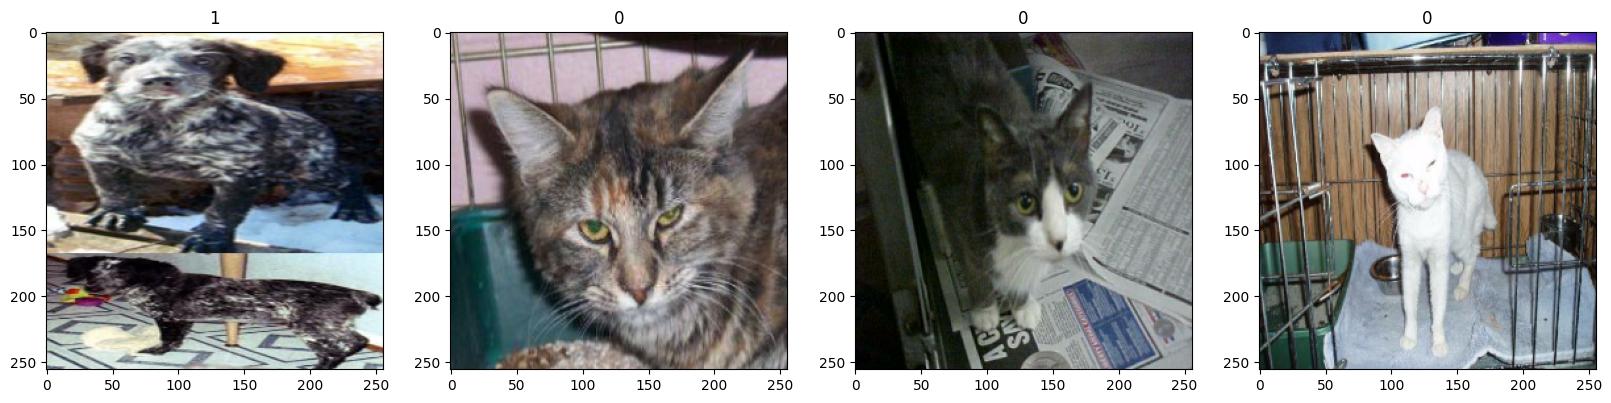

In [112]:
scaled_batch = data.as_numpy_iterator()
batch = scaled_batch.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

In [113]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)+1
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [173]:
model = Sequential()
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

e:\image-project\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [115]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])
model.summary()

In [117]:
logdir='logs'   
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 58s 161ms/step - accuracy: 0.5016 - loss: 0.7655 - val_accuracy: 0.5312 - val_loss: 0.7163
Epoch 2/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 53s 150ms/step - accuracy: 0.5556 - loss: 0.7104 - val_accuracy: 0.5525 - val_loss: 0.7082
Epoch 3/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 53s 150ms/step - accuracy: 0.5680 - loss: 0.6996 - val_accuracy: 0.5962 - val_loss: 0.7114
Epoch 4/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 53s 151ms/step - accuracy: 0.6393 - loss: 0.6734 - val_accuracy: 0.6575 - val_loss: 0.6874
Epoch 5/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 53s 150ms/step - accuracy: 0.6875 - loss: 0.6417 - val_accuracy: 0.6687 - val_loss: 0.7039
Epoch 6/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 53s 150ms/step - accuracy: 0.7359 - loss: 0.6166 - val_accuracy: 0.6913 - val_loss: 0.7139
Epoch 7/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 53s 151ms/step - accuracy: 0.7850 - loss: 0.5642 - val_accuracy: 0.7050 - val_loss: 0.7473
Epoch 8/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 53s 151ms/step - accuracy: 0.8183 - loss: 0

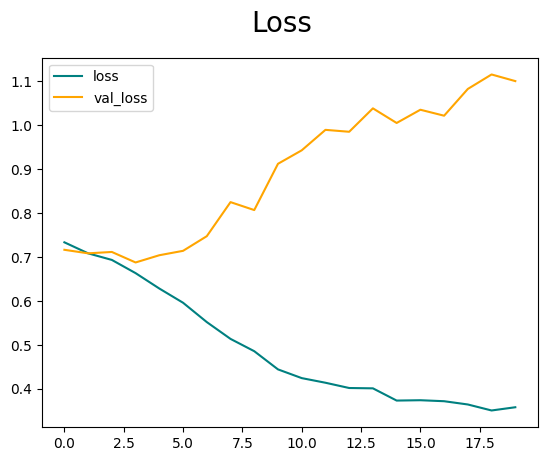

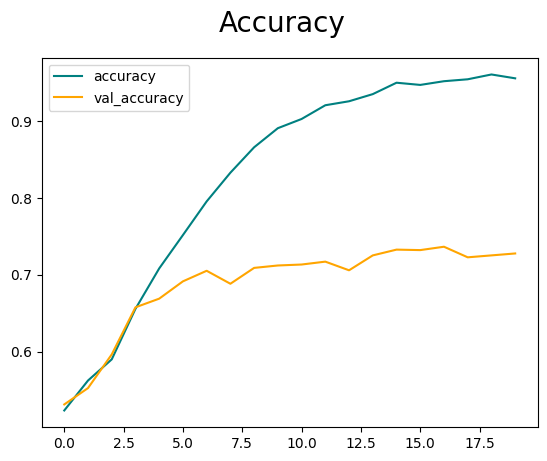

In [128]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [176]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
print(pre.result(), re.result(), acc.result())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━

In [184]:
img = cv2.imread('test\cats\cat.4387.jpg')
resize = tf.image.resize(img, (256,256))


<>:1: SyntaxWarning: invalid escape sequence '\c'
<>:1: SyntaxWarning: invalid escape sequence '\c'
C:\Users\mbhai\AppData\Local\Temp\ipykernel_5916\3862824826.py:1: SyntaxWarning: invalid escape sequence '\c'
  img = cv2.imread('test\cats\cat.4387.jpg')


In [185]:
yhat = model.predict(np.expand_dims(resize/255, 0))
print(yhat)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[[0.46126056]]


In [186]:
if yhat > 0.5: 
    print(f'Predicted class is dog')
else:
    print(f'Predicted class is cat')

Predicted class is cat


In [180]:
model.save(os.path.join('models', 'imageclassifier.h5'))
